# Export geometries to FEniCS and solve

content:
* [Single patch](#patch)
    * [Create geometry](#geometry)
    * [Assign Boundary Conditions labels](#bc)
    * [Export geometry with Gmsh](#gmsh)
    * [Convert to xdmf format](#fe)
    * [Run simulation with FEniCS](#fenics)
    * [Plot result](#plot)
* [Multi patch](#patches)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

<a id='patch'></a>
# Single patch

<a id='geometry'></a>
## 1) Create Geometry

In [2]:
cp = np.asarray([[[0,0],[-1,0],[-2,0]],
                 [[0,1], [-1,2], [-2,2]],
                 [[1, 1.5], [1,4],[1,5]],
                 [[3, 1.5],[3, 4],[3, 5]]])
U = np.asarray([0, 0, 0, 0.5, 1, 1, 1])       
V = np.asarray([0, 0, 0, 1, 1, 1])


In [3]:
from pygeoiga.nurb.nurb_creation import NURB

In [4]:
nrb = NURB(cp, [U,V])

<AxesSubplot:>

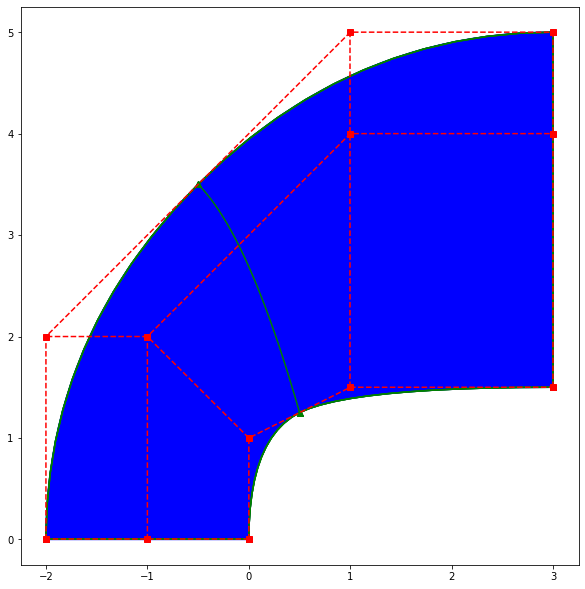

In [5]:
nrb.plot()

In [6]:
from pygeoiga.nurb.multipatch_NURBS import Multipatch
mult = Multipatch()

In [8]:
mult.add_patch(nrb, "biquadratic", kappa=10)
mult.define_topology()

True

## 3) Boundary conditions labels 

In [9]:
mult.assign_boundary_condition(name_patch = "biquadratic", id_boundary="bot_BC", face=0)
mult.assign_boundary_condition(name_patch = "biquadratic", id_boundary="top_BC", face=1)

True

In [10]:
for name in mult.geometry.keys():
    print(name, mult.geometry[name].get("BC"))

biquadratic {0: 'bot_BC', 1: 'top_BC'}


<a id='gmsh'></a>
## 2) Export geometry with Gmsh

In [11]:
from pygeoiga.nurb.nrb_to_gmsh import convert_geometry_mp_to_gmsh

In [12]:
mesh, script, physical_tag_id = convert_geometry_mp_to_gmsh(mult.geometry, 
                                                            size=1, # Size of the mesh 
                                                            save_geo=  "data/biquadratic.geo",
                                                            save_msh= "data/biquadratic.msh")
    

Info    : Running '/home/danielsk78/anaconda3/envs/IGA/lib/python3.7/site-packages/gmsh-4.7.1-Linux64-sdk/lib/../bin/gmsh -2 /tmp/tmpc0yd6xr3.geo -format msh2 -bin -o /tmp/tmpx0nxyp7z.msh' [Gmsh 4.7.1, 1 node, max. 1 thread]
Info    : Started on Mon Mar  1 03:25:58 2021
Info    : Reading '/tmp/tmpc0yd6xr3.geo'...
Info    : Done reading '/tmp/tmpc0yd6xr3.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 30%] Meshing curve 2 (Nurb)
Info    : [ 50%] Meshing curve 3 (Nurb)
Info    : [ 80%] Meshing curve 4 (Nurb)
Info    : Done meshing 1D (Wall 0.010151s, CPU 0.02209s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0034596s, CPU 0.008817s)
Info    : 38 nodes 72 elements
Info    : Writing '/tmp/tmpx0nxyp7z.msh'...
Info    : Done writing '/tmp/tmpx0nxyp7z.msh'
Info    : Stopped on Mon Mar  1 03:25:58 2021 (From start: Wall 0.0193761s, CPU 0.086206s)
2.2 8 False


<a id='fe'></a>
## 3) Export to xdmf format

In [13]:
from pygeoiga.FE_solvers.run_fenics import convert_msh_to_xdmf, run_simulation

In [14]:
convert_msh_to_xdmf("data/biquadratic.msh")

2.2 8 True
successfully saved in:data/biquadratic


<a id='fenics'></a>
## 3) Run simulation with fenics

  [+] Output to data/biquadratic_solution.pvd


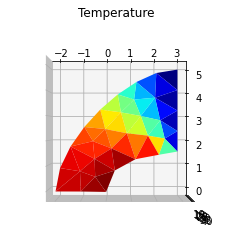

In [15]:
nodal_coordinates, temperature_nodes, mesh, u = run_simulation("data/biquadratic.msh", 
                                                      topology_info=physical_tag_id, 
                                                      top_bc=10, 
                                                      bot_bc=40,
                                                      geometry=mult.geometry, 
                                                      show=True)


## 4) Plotting

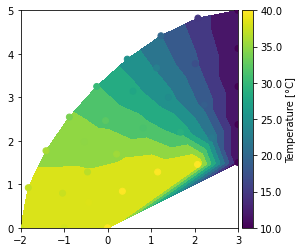

In [16]:
from pygeoiga.plot.solution_mpl import p_temperature
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax = p_temperature(nodal_coordinates[:,0],
                   nodal_coordinates[:,1],
                   temperature_nodes,
                   vmin=temperature_nodes.min(),
                   vmax=temperature_nodes.max(),
                   ax=ax,
                   point=True,
                   fill=True)
fig.show()

<a id='patches'></a>
# Multi patches

In [17]:
# Create multipatch structure
c_d1 = np.array([[[0, 0], [0, 100], [0, 200]],
                          [[50, 0], [85.5, 100], [121, 200]],
                          [[100, 0], [171, 100], [242, 200]]])
k_d1 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d1 = NURB(c_d1, k_d1)

c_d2 = np.array([[[100, 0], [171, 100], [242, 200]],
                 [[550, 0], [585.5, 100], [621, 200]],
                 [[1000, 0], [1000,  100], [1000,  200]]])
k_d2 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d2 = NURB(c_d2, k_d2)

c_d3 = np.array([[[0, 200], [0, 250], [0, 300]],
                 [[121, 200], [138, 250], [155, 300]],
                 [[242, 200],  [276, 250], [310, 300]]])
k_d3 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d3 = NURB(c_d3, k_d3)

c_d4 = np.array([[[ 242,  200], [ 276.,  250.], [ 310.,  300]],
                 [[ 621.,  200.], [ 638.,  250], [ 655.,  300.]],
                 [[1000.,  200.], [1000.,  250.], [1000.,  300.]]])
k_d4 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d4 = NURB(c_d4, k_d4)

c_d5 = np.array([[[  0., 300], [  0., 500], [  0., 700.]],
                 [[155., 300.], [225., 500.], [295., 700.]],
                 [[310., 300.], [450., 500], [590., 700]]])
k_d5 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d5 = NURB(c_d5, k_d5)

c_d6 = np.array([[[ 310.,  300], [ 450.,  500], [ 590.,  700]],
                 [[ 655.,  300], [ 725.,  500], [ 795.,  700]],
                 [[1000.,  300], [1000.,  500], [1000.,  700]]])
k_d6 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d6 = NURB(c_d6, k_d6)

c_d7 = np.array([[[  0. , 700], [  0. , 750], [  0. , 800.]],
                 [[295. , 700], [312.5, 750], [330. , 800]],
                 [[590. , 700], [625. , 750], [660. , 800]]])
k_d7 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d7 = NURB(c_d7, k_d7)

c_d8 = np.array([[[ 590. ,  700], [ 625. ,  750], [ 660. ,  800]],
              [[ 795. ,  700], [ 812.5,  750], [ 830. ,  800]],
              [[1000. ,  700], [1000. ,  750], [1000. ,  800]]])
k_d8 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d8 = NURB(c_d8, k_d8)

c_d9 = np.array([[[   0.,  800], [   0.,  900], [ 0., 1000]],
                 [[ 330.,  800], [ 365.,  900], [ 400., 1000]],
                  [[660.,  800], [ 730.,  900], [ 800., 1000]]])
k_d9 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d9 = NURB(c_d9, k_d9)

c_d10 = np.array([[[ 660.,  800.], [ 730.,  900], [ 800., 1000]],
                  [[ 830.,  800], [ 865.,  900], [ 900., 1000]],
                  [[1000.,  800], [1000.,  900], [1000., 1000]]])
k_d10 = [[0, 0, 0, 1, 1, 1], [0, 0, 0, 1, 1, 1]]
nrb_d10 = NURB(c_d10, k_d10)


In [18]:
from pygeoiga.nurb.multipatch_NURBS import Multipatch

In [19]:
r = 3.1 #Thermal conductivity
b = 0.9 #Thermal conductivity
y = 3 #Thermal conductivity

mult2 = Multipatch()
mult2.add_patch(nrb_d1, "d1", position=(1,1), kappa = r)
mult2.add_patch(nrb_d2, "d2", position=(1,2), kappa = r)
mult2.add_patch(nrb_d3, "d3", position=(2,1), kappa = r)
mult2.add_patch(nrb_d4, "d4", position=(2,2), kappa = b)
mult2.add_patch(nrb_d5, "d5", position=(3,1), kappa = r)
mult2.add_patch(nrb_d6, "d6", position=(3,2), kappa = y)
mult2.add_patch(nrb_d7, "d7", position=(4,1), kappa = b)
mult2.add_patch(nrb_d8, "d8", position=(4,2), kappa = y)
mult2.add_patch(nrb_d9, "d9", position=(5,1), kappa = y)
mult2.add_patch(nrb_d10, "d10", position=(5,2), kappa = y)

In [20]:
mult2.define_topology()

True

In [21]:
mult2.assign_boundary_condition(name_patch = "d1", id_boundary="bot_BC", face=0)
mult2.assign_boundary_condition(name_patch = "d2", id_boundary="bot_BC", face=0)
mult2.assign_boundary_condition(name_patch = "d9", id_boundary="top_BC", face=2)
mult2.assign_boundary_condition(name_patch = "d10", id_boundary="top_BC", face=2)

True

In [22]:
for name in mult2.geometry.keys():
    print(name, mult2.geometry[name].get("BC"))

d1 {0: 'bot_BC'}
d2 {0: 'bot_BC'}
d3 None
d4 None
d5 None
d6 None
d7 None
d8 None
d9 {2: 'top_BC'}
d10 {2: 'top_BC'}


In [23]:
mesh, script, physical_tag_id = convert_geometry_mp_to_gmsh(mult2.geometry, 
                                                            size=90, # Size of the mesh 
                                                            save_geo=  "data/fault.geo",
                                                            save_msh= "data/fault.msh")
    

Info    : Running '/home/danielsk78/anaconda3/envs/IGA/lib/python3.7/site-packages/gmsh-4.7.1-Linux64-sdk/lib/../bin/gmsh -2 /tmp/tmpk9s9mj22.geo -format msh2 -bin -o /tmp/tmplvf4obhk.msh' [Gmsh 4.7.1, 1 node, max. 1 thread]
Info    : Started on Mon Mar  1 03:26:05 2021
Info    : Reading '/tmp/tmpk9s9mj22.geo'...
Info    : Done reading '/tmp/tmpk9s9mj22.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Nurb)
Info    : [ 10%] Meshing curve 2 (Nurb)
Info    : [ 10%] Meshing curve 3 (Nurb)
Info    : [ 20%] Meshing curve 4 (Nurb)
Info    : [ 20%] Meshing curve 7 (Nurb)
Info    : [ 20%] Meshing curve 8 (Nurb)
Info    : [ 30%] Meshing curve 9 (Nurb)
Info    : [ 30%] Meshing curve 12 (Nurb)
Info    : [ 30%] Meshing curve 13 (Nurb)
Info    : [ 40%] Meshing curve 14 (Nurb)
Info    : [ 40%] Meshing curve 17 (Nurb)
Info    : [ 50%] Meshing curve 18 (Nurb)
Info    : [ 50%] Meshing curve 21 (Nurb)
Info    : [ 50%] Meshing curve 22 (Nurb)
Info    : [ 60%] Meshing curve 23 (Nurb)
Info   

In [24]:
convert_msh_to_xdmf("data/fault.msh")

2.2 8 True
successfully saved in:data/fault


  [+] Output to data/fault_solution.pvd


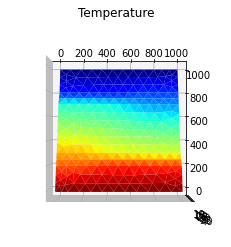

In [25]:
nodal_coordinates, temperature_nodes, mesh, u = run_simulation("data/fault.msh", 
                                                      topology_info=physical_tag_id, 
                                                      top_bc=10, 
                                                      bot_bc=40,
                                                      geometry=mult2.geometry, 
                                                      show=True)


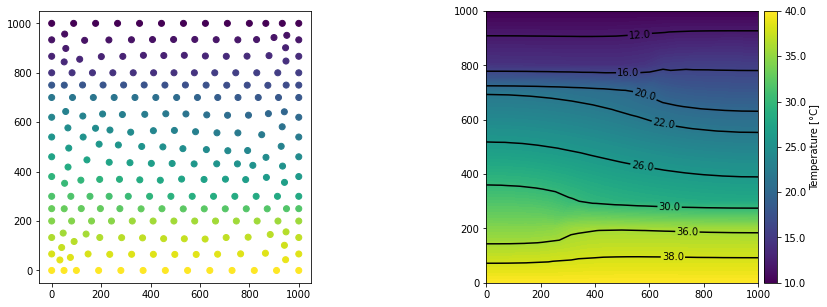

In [26]:
from pygeoiga.plot.solution_mpl import p_temperature
fig, [ax1, ax] = plt.subplots(1, 2, figsize=(15,5))
ax1.set_aspect("equal")

ax.set_aspect("equal")


ax1 = p_temperature(nodal_coordinates[:,0],
                   nodal_coordinates[:,1],
                   temperature_nodes,
                   vmin=temperature_nodes.min(),
                   vmax=temperature_nodes.max(),
                   ax=ax1,
                   point=True,
                   fill=False, 
                    colorbar=True)

ax = p_temperature(nodal_coordinates[:,0],
                   nodal_coordinates[:,1],
                   temperature_nodes,
                   vmin=temperature_nodes.min(),
                   vmax=temperature_nodes.max(),
                   ax=ax,
                   point=False,
                   fill=True,
                   levels=100, 
                   colorbar=False)
ax = p_temperature(nodal_coordinates[:,0],
                   nodal_coordinates[:,1],
                   temperature_nodes,
                   vmin=temperature_nodes.min(),
                   vmax=temperature_nodes.max(),
                   ax=ax,
                   point=False,
                   fill=False,
                   contour=True,
                   levels=[12, 16, 20, 22, 26, 30, 36, 38],
                  colorbar=True)
fig.show()